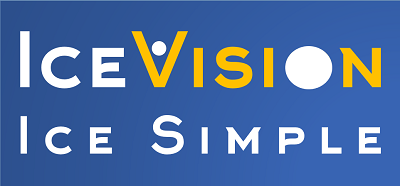

# 🧊 Loading icevision

In [ ]:
!pip install icevision[all] > /dev/null

# 📚 Importing Libraries

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
from PIL import Image
import glob
from tqdm.notebook import tqdm
from icevision.all import *
import ast

# ⚙️ Parse the dataset

In [ ]:
WIDTH = 1280
HEIGHT= 720

def get_bbox(annots):
    bboxes = [list(annot.values()) for annot in annots]
    return bboxes

In [ ]:
PATH = "../input/tensorflow-great-barrier-reef/train_images/**"
images = glob.glob(PATH + '/*.jpg')
dataset = pd.read_csv('../input/tensorflow-great-barrier-reef/train.csv')
dataset["num_bbox"] = dataset['annotations'].apply(lambda x: str.count(x, 'x'))
dataset = dataset[dataset["num_bbox"]>0]
dataset['annotations'] = dataset['annotations'].apply(lambda x: ast.literal_eval(x))
dataset['bboxes'] = dataset.annotations.apply(get_bbox)
dataset['video_frame'] = dataset['video_frame'].apply(lambda x: str(x)+ '.jpg')
dataset["video_id"] = dataset['video_id'].apply(lambda x: 'video_' + str(x))
dataset['paths'] = '../input/tensorflow-great-barrier-reef/train_images/'+ dataset['video_id'] + '/' + dataset['video_frame'] 
dataset['label'] = 'Fish'

In [ ]:
def show_sample_image(n=2):
    img_index = list(np.round((np.random.random(n))*len(dataset)))
    fig,ax = plt.subplots(1,n,figsize=(10,10))
    i = 0
    for idx in img_index:
        img = dataset.paths.values[int(idx)]
        img = Image.open(img)
        if n == 1:ax.imshow(img)
        else:ax[i].imshow(img)
            
        annot = dataset.bboxes.values[int(idx)]
        for a in range(len(annot)):
            xmin = annot[a][0]
            ymin = annot[a][1]
            width = annot[a][2]
            height = annot[a][3]
            rect = patches.Rectangle((xmin, ymin), width, height, linewidth=3, edgecolor='r', facecolor='none')
            if n==1:ax.add_patch(rect)
            else:ax[i].add_patch(rect)
        i = i+1
    plt.show()
    return None

In [ ]:
show_sample_image(n=1)

In [ ]:
training_df = pd.DataFrame(columns = ['img','xmin','ymin','label','width','height'])

for i in tqdm(range(len(dataset))):
    annot = dataset.iloc[i].bboxes
    annot_array = np.array(annot)
    label = np.array([dataset.iloc[i].label] * annot_array.shape[0])
    xmin = annot_array[:,0]
    ymin = annot_array[:,1]
    width = annot_array[:,2]
    height = annot_array[:,3]
    img = str(dataset.iloc[i].paths)
    inter_df = pd.DataFrame({'img':img,'label':label,'xmin':xmin,'ymin':ymin,'width':width,'height':height})
    training_df = training_df.append(inter_df)

In [ ]:
template_record = ObjectDetectionRecord()

In [ ]:
class MyParser(Parser):
    def __init__(self, template_record):
        super().__init__(template_record=template_record)

        self.df = training_df
        self.class_map = ClassMap(list(self.df['label'].unique()))

    def __iter__(self) -> Any:
        for o in self.df.itertuples():
            yield o

    def __len__(self) -> int:
        return len(self.df)

    def record_id(self, o) -> Hashable:
        return o.img

    def parse_fields(self, o, record, is_new):
        if is_new:
            record.set_filepath(o.img)
            record.set_img_size(ImgSize(width=WIDTH, height=HEIGHT))
            record.detection.set_class_map(self.class_map)
            
        record.detection.add_bboxes([BBox.from_xyxy(o.xmin, o.ymin, o.xmin + o.width, o.ymin + o.height)])
        record.detection.add_labels([o.label])

In [ ]:
parser = MyParser(template_record)

In [ ]:
train_records, valid_records = parser.parse()

In [ ]:
parser.class_map

In [ ]:
train_records[10]

In [ ]:
show_record(train_records[1], display_label=True, figsize=(14, 10))

## augmentation

In [ ]:
# Transforms
# size is set to 384 because EfficientDet requires its inputs to be divisible by 128
image_size = 384
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=image_size, presize=512), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(image_size), tfms.A.Normalize()])

In [ ]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

In [ ]:
samples = [train_ds[0] for _ in range(3)]
show_samples(samples, ncols=3)

# 🏗️ creating your model

In [ ]:
extra_args = {}
model_type = models.ross.efficientdet
backbone = model_type.backbones.tf_lite0
# The efficientdet model requires an img_size parameter
extra_args['img_size'] = image_size

In [ ]:
model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(parser.class_map), **extra_args) 

In [ ]:
train_dl = model_type.train_dl(train_ds, batch_size=32, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=32, shuffle=False)

# 👨‍🏫 model training

In [ ]:
learn = model_type.fastai.learner(dls=[train_dl,valid_dl], model=model)

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(10, 1e-2, freeze_epochs=1)

# ✨ model inference 

In [ ]:
infer_dl = model_type.infer_dl(valid_ds, batch_size=4, shuffle=False)
preds = model_type.predict_from_dl(model, infer_dl, keep_images=True,detection_threshold=0.2)

In [ ]:
img_number = 10
pred_bboxes_list, gt_bboxes_list = [], []
pred_bboxes = preds[img_number].pred.as_dict()['detection']['bboxes']
ground_truth_bboxes = preds[img_number].ground_truth.as_dict()['detection']['bboxes']
preds_df = pd.DataFrame(columns=['x','y','width','height'])
gt_df = pd.DataFrame(columns=['x','y','width','height'])

if len(pred_bboxes) > 0:
    for box in pred_bboxes:
        pred_bboxes_list.append([box.xmin,box.ymin,box.xmax - box.xmin,box.ymax - box.ymin])
    preds_df[['x','y','width','height']] = pred_bboxes_list
    preds_df = preds_df.astype(int)
    
if len(ground_truth_bboxes) > 0:
    for box in ground_truth_bboxes:
        gt_bboxes_list.append([box.xmin,box.ymin,box.xmax - box.xmin,box.ymax - box.ymin])
    gt_df[['x','y','width','height']] = gt_bboxes_list
    gt_df = gt_df.astype(int)    

In [ ]:
print(f'predicted bboxes of image-{img_number}')
preds_df

In [ ]:
print(f'ground truth bboxes of image-{img_number}')
gt_df

In [ ]:
show_preds(preds=preds[10:11],figsize=(15,15))

# 🔎 references

## kaggle kernels

1- https://www.kaggle.com/aninda/icevision/data

2- https://www.kaggle.com/nyanswanaung/cots-coco-stratifiedk-5-folds-4919-imgs

## Ice vision official website
 
https://airctic.com/0.11.0/getting_started_object_detection/